This notebook first generate several random sound files and feed the data into the training model of cnn.
The CNN model should learn to classify each sound and give the output.

### Import libraries

In [2]:
import matplotlib.pyplot as plt

from scipy.io import wavfile
import scipy.signal
import numpy as np
np.set_printoptions(threshold=np.nan)
import time
import fluidsynth

import tensorflow as tf
import os
from scipy import signal
from scipy.fftpack import fft, ifft
from imageio import imread
from random import shuffle

from IPython.display import Audio
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, Flatten
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [33]:
def generate_data(n, t=0.125):
    # in this function, user enter the number of training data and the function will return a list
    # that contains the data and the label
    # By calling this fucntion, we can get the training data and the test data
    fl = fluidsynth.Synth(gain=3) #gain=[0,10]
    fl.audio_driver="alsa"
    sfid = fl.sfload("Wii_Grand_Piano.sf2")

    fl.program_select(0, sfid, 0, 0)
    _ = fl.cc(0, 7, 110) #fl.cc(0,7,50): chanel 0 volume is 50, range=0~127 np.random.uniform(40,100)

    data_length = 4096
    data_set = []
    # length of data after fft is 4096 = 64x64
    # we need to reshape the data to a 2D array in order to do the convolution
    data = np.zeros((n, 64, 64, 1))
    # label is one-hot coded
    label = np.zeros((n, 7))
    #fs.start("alsa")
    for i in range(n):
    
        _ = fl.cc(0,11, np.random.randint(75,85)) #fl.cc(0,11,50): chanel 0 expression is 50, range=0~127 (0: soft, 127: hard)
        s=np.zeros((1,),dtype=np.int16)

        s = np.append(s, fl.get_samples(int(44100 * 0.2))[::2]) # we give 0.2 seconds of silent at first

        music = np.array([60,62,64,65,67,69,71])
        midiNum=int(np.random.choice(music))
        # write label to label array
        label[i] = (midiNum==music).astype(float)
        fl.noteon(0, midiNum, int(np.random.randint(30,100)))

        #time.sleep(1.0)
        s = np.append(s, fl.get_samples(int(44100 * np.random.uniform(2, 3)))[::2])


        fl.noteoff(0, midiNum)
        #time.sleep(1.0)

        s = np.append(s, fl.get_samples(44100 * 1)[::2])
        # record the data
        L = s.shape[0]
        offset = int(L/2)
        sound_data = s[offset:offset+data_length]
        freq = fft(sound_data, n=4096)
        data[i,:,:,0] = np.abs(freq.reshape(64, 64))

        #plt.plot(s)
        #plt.show()



        #wavfile.write("a"+str(i)+"wav",44100,s)

    fl.delete()
    return [data, label]

In [34]:
def cnn_keras(x_train, y_train, batch_size, epochs, x_test, y_test):
    # several steps
    # 1. construct the model
    # 2. compile the model
    # 3. train the model with the input data
    model = Sequential()

    model.add(Conv2D(3, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="valid"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(12, 12), strides=(12, 12)))
    model.add(Flatten())
    model.add(Dense(30, init='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(7, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.SGD(lr=0.1),
                  metrics=['accuracy'])

    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test),
              callbacks=[history])
    
    return model

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))
        self.loss.append(logs.get('loss'))

## Create Data Set

In [35]:
start_time = time.time()
train_set = generate_data(2000)
val_set = generate_data(800)
elapsed_time = time.time() - start_time
print("elapsed time is", elapsed_time)

elapsed time is 57.527148962020874


In [36]:
history = AccuracyHistory()
model = cnn_keras(train_set[0], train_set[1], 16, 20, val_set[0], val_set[1])

/Users/tonyzyc/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, kernel_initializer="uniform")`
  if sys.path[0] == '':


Train on 2000 samples, validate on 800 samples
Epoch 1/20
2000/2000 [==============================] - 5s 2ms/step - loss: 0.4842 - acc: 0.8860 - val_loss: 0.1932 - val_acc: 0.9988
Epoch 2/20
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2062 - acc: 0.9510 - val_loss: 0.1080 - val_acc: 1.0000
Epoch 3/20
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1533 - acc: 0.9590 - val_loss: 0.0740 - val_acc: 1.0000
Epoch 4/20
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1158 - acc: 0.9745 - val_loss: 0.0611 - val_acc: 1.0000
Epoch 5/20
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1010 - acc: 0.9770 - val_loss: 0.0427 - val_acc: 1.0000
Epoch 6/20
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0836 - acc: 0.9795 - val_loss: 0.0415 - val_acc: 1.0000
Epoch 7/20
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0725 - acc: 0.9875 - val_loss: 0.0539 - val_acc: 1.0000
Epoch 8/20
2000

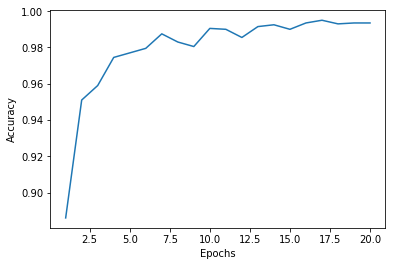

In [37]:
plt.plot(range(1,21), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

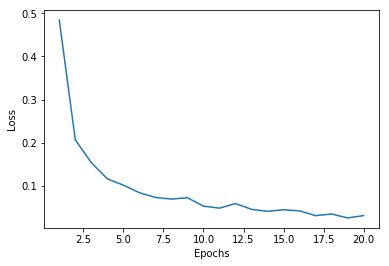

In [38]:
plt.plot(range(1,21), history.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [39]:
score = model.evaluate(train_set[0], train_set[1], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.007024107046425343
Test accuracy: 1.0


In [3]:
from scipy.io import wavfile
import scipy.signal
import numpy as np
np.set_printoptions(threshold=np.nan)
import time
import fluidsynth

from random import shuffle

def f(total_duration=10, note_duration=2.5):
    # in this function, user enter the number of training data and the function will return a list
    # that contains the data
    sample_rate = 44100
    # N is the total sample points and n is the total number of notes
    N = int(sample_rate * total_duration)
    n = int(total_duration/note_duration)
    fl = fluidsynth.Synth(gain=3) #gain=[0,10]
    fl.audio_driver="alsa"
    sfid = fl.sfload("Wii_Grand_Piano.sf2")

    fl.program_select(0, sfid, 0, 0)
    _ = fl.cc(0, 7, 110) #fl.cc(0,7,50): chanel 0 volume is 50, range=0~127 np.random.uniform(40,100)
    # there are 7 music nodes to choose from
    music = np.array([60, 62, 64, 65, 67, 69, 71])
    data = []
    #fs.start("alsa")
    for i in range(n):

        _ = fl.cc(0,11, np.random.randint(75,85)) #fl.cc(0,11,50): chanel 0 expression is 50, range=0~127 (0: soft, 127: hard)
        quiet = fl.get_samples(int(sample_rate * 0.2))[::2] # we give 0.2 seconds of silent at first
        data.append(quiet)


        midiNum=int(np.random.choice(music))
        fl.noteon(0, midiNum, int(np.random.randint(30,100)))

        #time.sleep(1.0)
        s = fl.get_samples(int(44100 * (note_duration-0.2)))[::2]
        data.append(s)


        fl.noteoff(0, midiNum)

    fl.delete()
    data = np.hstack(data)
    return data

In [4]:
a = f()

In [5]:
a.shape

(440996,)